Imported Libraries

In [ ]:
import os, torch, random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF 
from tqdm import tqdm

Resize image and mask to a fixed size (256x256) and convert to Tensor.

In [ ]:
def transform(image, mask):
    image = TF.resize(image, (256, 256))
    image = TF.to_tensor(image)

    mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)
    # integers needed for CrossEntropyLoss
    mask = torch.as_tensor(np.array(mask), dtype=torch.long)
    
    return image, mask

Define the dataset class

In [ ]:
class COCOSegmentationDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None, target_classes=None):
        self.root_dir = root_dir
        self.coco = COCO(ann_file)
        self.transform = transform
        
        # keep only images containing specific categories
        if target_classes:
            self.cat_ids = self.coco.getCatIds(catNms=target_classes)
            self.ids = []
            for cat_id in self.cat_ids:
                self.ids.extend(self.coco.getImgIds(catIds=[cat_id]))
            self.ids = list(set(self.ids)) # Remove duplicates
        else:
            self.cat_ids = self.coco.getCatIds()
            self.ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        
        # Change from polygon masks to pixel
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=self.cat_ids)
        anns = coco.loadAnns(ann_ids)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        
        for ann in anns:
            pixel_value = ann['category_id']
            ann_mask = coco.annToMask(ann)
            # Combining all into one channel (max for handling overlaps)
            mask = np.maximum(mask, ann_mask * pixel_value)

        mask = Image.fromarray(mask)

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

Define a function to visualize the dataset

In [ ]:
def visualize_batch(dataset, num_samples=3):

    indices = random.sample(range(len(dataset)), num_samples)
    _, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    if num_samples == 1: axes = [axes] # for single sample case
        
    for i, idx in enumerate(indices):
        image_tensor, mask_tensor = dataset[idx]
        
        # H, W, C for visualization
        image_np = image_tensor.permute(1, 2, 0).numpy()
        mask_np = mask_tensor.numpy()
        
        axes[i][0].imshow(image_np)
        axes[i][0].set_title(f"Image #{idx}")
        axes[i][0].axis('off')
        
        axes[i][1].imshow(mask_np, cmap='jet', interpolation='nearest')
        axes[i][1].set_title("Ground Truth Mask")
        axes[i][1].axis('off')
        
        axes[i][2].imshow(image_np)
        masked_overlay = np.ma.masked_where(mask_np == 0, mask_np)
        axes[i][2].imshow(masked_overlay, cmap='jet', alpha=0.5)
        axes[i][2].set_title("Overlay")
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()

Create the dataset but filter for 'person' instead of using all of the dataset classes. Then print some random images to visualize data. Make sure paths are correct

Initializing Dataset...
loading annotations into memory...
Done (t=15.45s)
creating index...
index created!
Dataset was created with 64115 images.
Visualizing random samples...


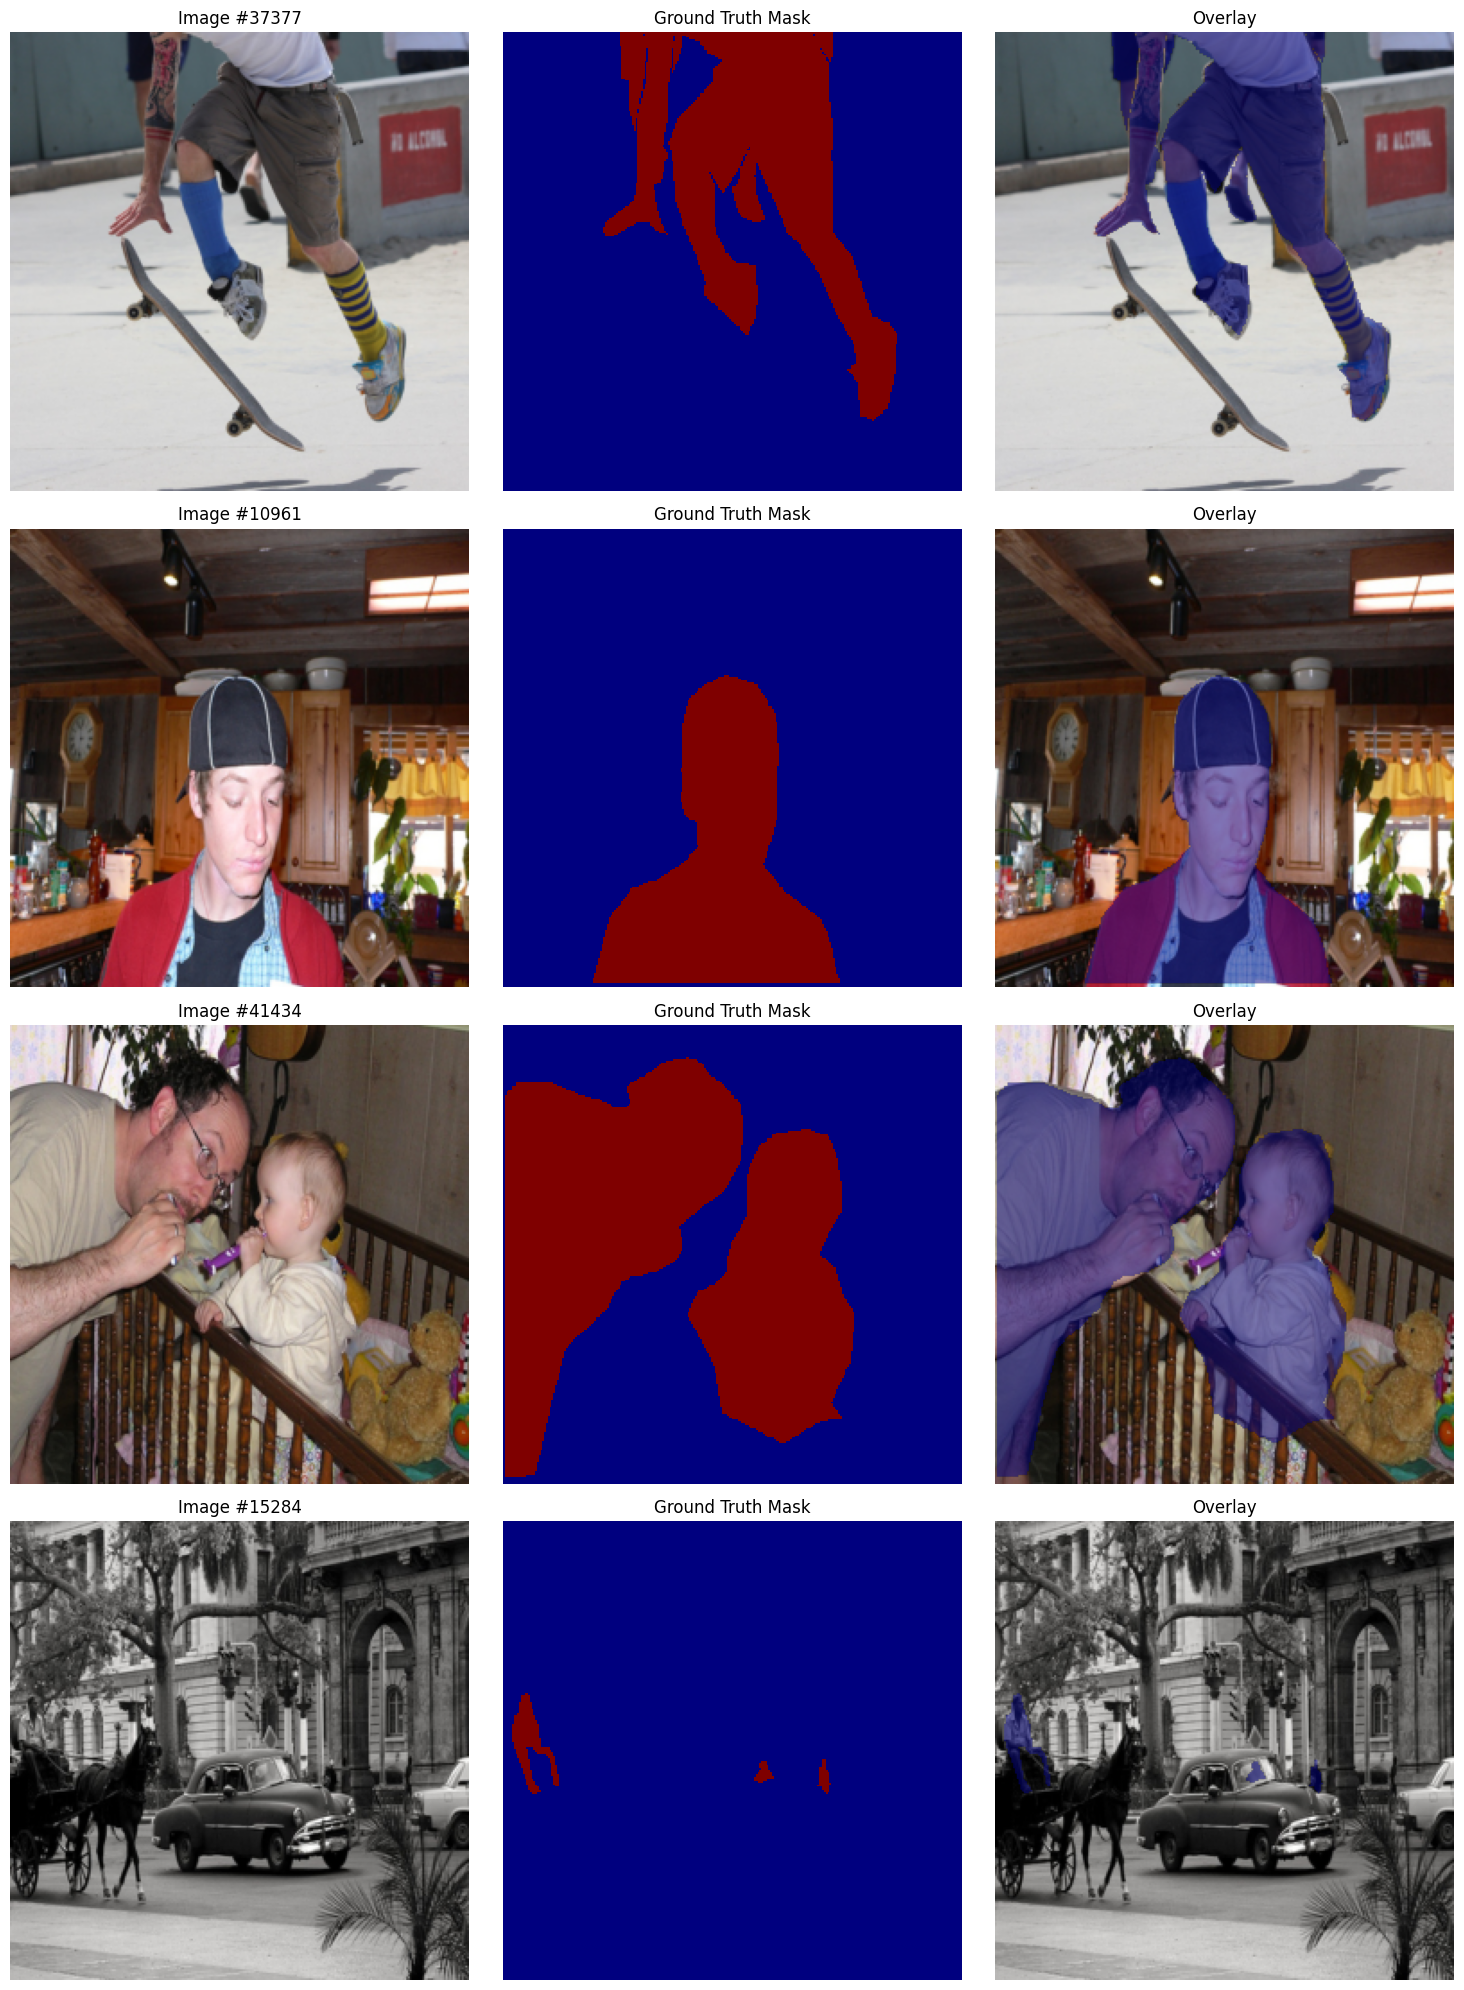

In [ ]:
data_path = './coco/train2017' 
ann_path = './coco/annotations/instances_train2017.json'

val_data_path = './coco/val2017'
val_ann_file = './coco/annotations/instances_val2017.json'

print("Initializing Dataset...")

train_set = COCOSegmentationDataset(
    root_dir=data_path, 
    ann_file=ann_path, 
    transform=transform,
    target_classes=['person']
)

print(f"Dataset made with {len(train_set)} images.")

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)

visualize_batch(train_set, num_samples=4)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.pool = nn.MaxPool2d(2)
        
        # contracting path

        self.inc = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        # expanding path
        self.up1_sample = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up1_conv = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.up2_sample = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2_conv = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.up3_sample = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up3_conv = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.up4_sample = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up4_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # encoder
        x1 = self.inc(x)
        x2 = self.pool(x1)          
        x2 = self.down1(x2)
        
        x3 = self.pool(x2)
        x3 = self.down2(x3)
        
        x4 = self.pool(x3)
        x4 = self.down3(x4)
        
        x5 = self.pool(x4)
        x5 = self.down4(x5)
        # decoder
        x = self.up1_sample(x5)
        # pad if dimensions don't match because of odd sizes
        diffY = x4.size(2) - x.size(2)
        diffX = x4.size(3) - x.size(3)
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # skip connections
        x = torch.cat([x4, x], dim=1)
        x = self.up1_conv(x)
        
        x = self.up2_sample(x)
        diffY = x3.size(2) - x.size(2)
        diffX = x3.size(3) - x.size(3)
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x3, x], dim=1)
        x = self.up2_conv(x)

        x = self.up3_sample(x)
        diffY = x2.size(2) - x.size(2)
        diffX = x2.size(3) - x.size(3)
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x], dim=1)
        x = self.up3_conv(x)
        
        x = self.up4_sample(x)
        diffY = x1.size(2) - x.size(2)
        diffX = x1.size(3) - x.size(3)
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x1, x], dim=1)
        x = self.up4_conv(x)

        logits = self.outc(x)
        return logits

In [ ]:
# Hyperparameters
MOMENTUM = 0.99
LEARNING_RATE = 1e-3
LEARNING_RATE = 0.001 
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_WORKERS = 2

In [ ]:
val_set = COCOSegmentationDataset(
    root_dir=val_data_path, 
    ann_file=val_ann_file, 
    transform=transform,
    target_classes=['person']
)

val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train size: {len(train_set)} | Val size: {len(val_set)}")

loading annotations into memory...
Done (t=16.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Train size: 64115 | Val size: 2693


Initialize weights and start training loop

Training with SGD (Momentum: 0.99) on cuda
Starting Training Loop...


Epoch 1/10 [Train]: 100%|████████████████████████████████████████| 2004/2004 [13:46<00:00,  2.42it/s, train_loss=0.328]


Epoch 1 Results: Train Loss: 0.3493 | Val Loss: 0.2944 | LR: 0.001000


Epoch 2/10 [Train]: 100%|████████████████████████████████████████| 2004/2004 [13:36<00:00,  2.45it/s, train_loss=0.238]


Epoch 2 Results: Train Loss: 0.2736 | Val Loss: 0.2618 | LR: 0.001000


Epoch 3/10 [Train]: 100%|████████████████████████████████████████| 2004/2004 [13:20<00:00,  2.50it/s, train_loss=0.182]


Epoch 3 Results: Train Loss: 0.2448 | Val Loss: 0.2409 | LR: 0.001000


Epoch 4/10 [Train]: 100%|████████████████████████████████████████| 2004/2004 [13:18<00:00,  2.51it/s, train_loss=0.195]


Epoch 4 Results: Train Loss: 0.2247 | Val Loss: 0.2250 | LR: 0.001000


Epoch 5/10 [Train]: 100%|█████████████████████████████████████████| 2004/2004 [13:18<00:00,  2.51it/s, train_loss=0.16]


Epoch 5 Results: Train Loss: 0.2106 | Val Loss: 0.2132 | LR: 0.001000


Epoch 6/10 [Train]: 100%|████████████████████████████████████████| 2004/2004 [13:38<00:00,  2.45it/s, train_loss=0.151]


Epoch 6 Results: Train Loss: 0.1973 | Val Loss: 0.2005 | LR: 0.001000


Epoch 7/10 [Train]: 100%|████████████████████████████████████████| 2004/2004 [13:39<00:00,  2.44it/s, train_loss=0.196]


Epoch 7 Results: Train Loss: 0.1868 | Val Loss: 0.1932 | LR: 0.001000


Epoch 8/10 [Train]: 100%|████████████████████████████████████████| 2004/2004 [13:40<00:00,  2.44it/s, train_loss=0.217]


Epoch 8 Results: Train Loss: 0.1768 | Val Loss: 0.1851 | LR: 0.001000


Epoch 9/10 [Train]: 100%|████████████████████████████████████████| 2004/2004 [13:39<00:00,  2.45it/s, train_loss=0.203]


Epoch 9 Results: Train Loss: 0.1687 | Val Loss: 0.1795 | LR: 0.001000


Epoch 10/10 [Train]: 100%|███████████████████████████████████████| 2004/2004 [13:38<00:00,  2.45it/s, train_loss=0.166]


Epoch 10 Results: Train Loss: 0.1608 | Val Loss: 0.1761 | LR: 0.001000
Training Complete.


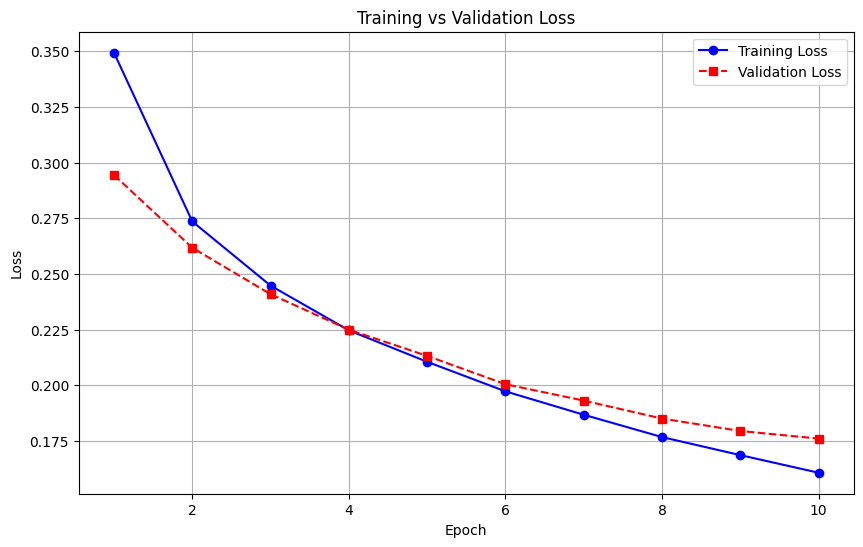

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training with SGD, Momentum: {MOMENTUM} on {device}")

model = UNet(n_channels=3, n_classes=2).to(device)

# "He" initialization important for SGD
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(weights_init)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

train_loss_history = []
val_loss_history = []

print("Training...")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_train_loss = 0
    loop = tqdm(train_loader, leave=True, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)
        
        predictions = model(images)
        loss = criterion(predictions, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        loop.set_postfix(train_loss=loss.item())
        
    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    running_val_loss = 0
    
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            
            val_preds = model(val_images)
            v_loss = criterion(val_preds, val_masks)
            
            running_val_loss += v_loss.item()
            
    avg_val_loss = running_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    torch.save(model.state_dict(), f'unet_sgd_epoch_{epoch+1}.pth')

print("Training Complete.")


plt.figure(figsize=(10, 6))
epochs_range = range(1, NUM_EPOCHS + 1)

plt.plot(epochs_range, train_loss_history, marker='o', color='blue', label='Training Loss')
plt.plot(epochs_range, val_loss_history, marker='s', color='red', linestyle='--', label='Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Loading model from unet_sgd_epoch_10.pth...
Selecting 3 random images from ./coco/test2017...


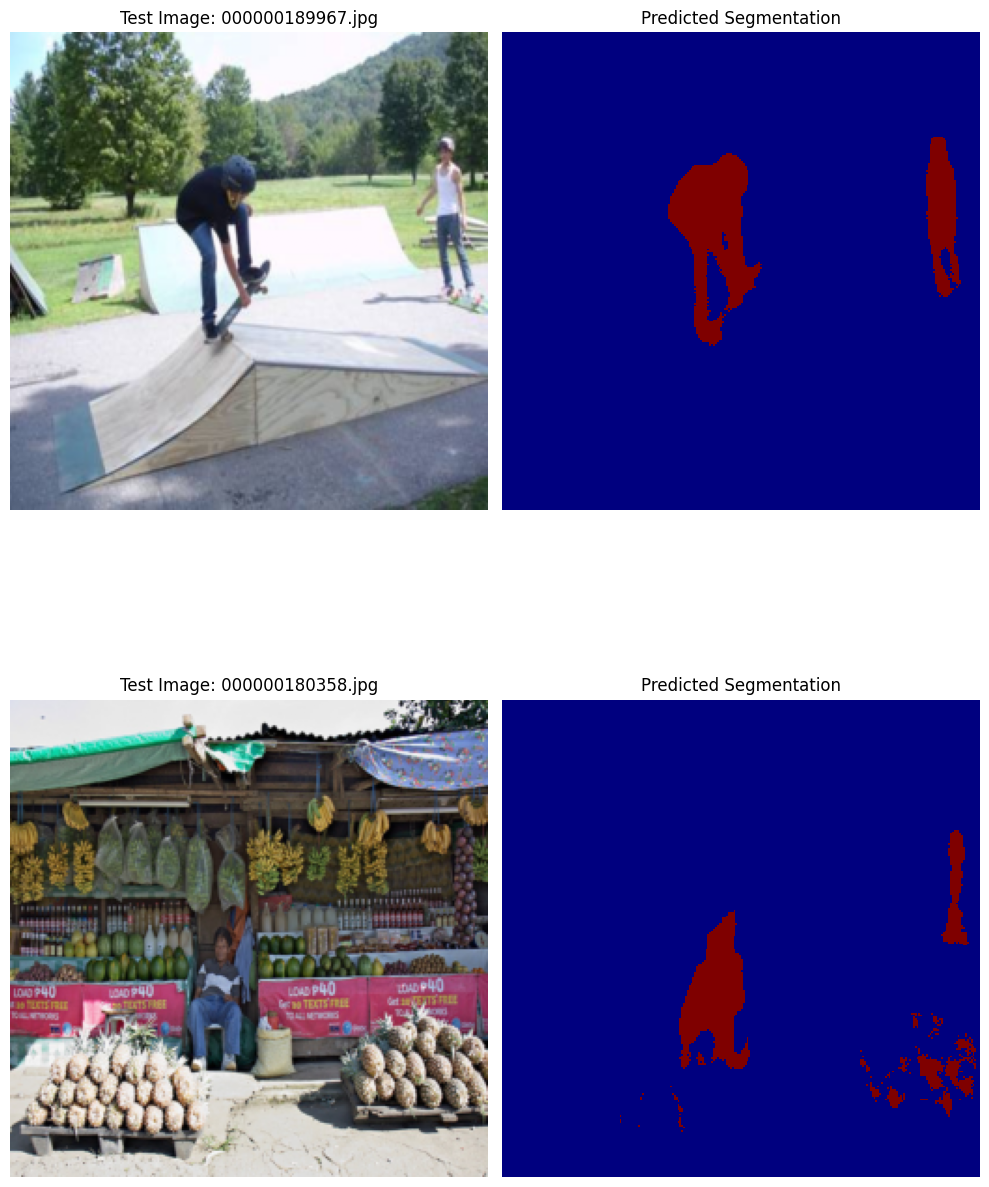

In [ ]:
TEST_IMG_DIR = './coco/test2017' 
MODEL_PATH = 'unet_sgd_epoch_10.pth'

def load_random_test_images(img_dir, num_images=3):
    all_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
    
    if len(all_files) == 0:
        raise ValueError(f"No images found in {img_dir}")
        
    selected_files = random.sample(all_files, num_images)
    
    loaded_data = []
    
    for fname in selected_files:
        path = os.path.join(img_dir, fname)
        original_image = Image.open(path).convert('RGB')
        
        # resize to 256x256 because U-Net expects a consistent input size 
        # that matches training.
        input_image = TF.resize(original_image, (256, 256))
        input_tensor = TF.to_tensor(input_image)
        
        loaded_data.append({
            'fname': fname,
            'original': original_image,
            'tensor': input_tensor
        })
        
    return loaded_data

print(f"Loading model from {MODEL_PATH}")
model = UNet(n_channels=3, n_classes=2).to(device)

state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print(f"Selecting 3 random images from {TEST_IMG_DIR}...")

try:
    test_samples = load_random_test_images(TEST_IMG_DIR, num_images=2)
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 15))
    
    with torch.no_grad():
        for i, sample in enumerate(test_samples):
            input_batch = sample['tensor'].unsqueeze(0).to(device)
            
            logits = model(input_batch)
            preds = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
            
            # Input Image
            input_display = sample['tensor'].permute(1, 2, 0).numpy()
            axes[i][0].imshow(input_display)
            axes[i][0].set_title(f"Test Image: {sample['fname']}")
            axes[i][0].axis('off')
            
            # Predicted Mask
            axes[i][1].imshow(preds, cmap='jet', interpolation='nearest')
            axes[i][1].set_title("Predicted Segmentation")
            axes[i][1].axis('off')
            
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find directory {TEST_IMG_DIR}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")